### Testing Least squares delay filter from uvtools.dspec

In this notebook, I am testing the features of the function delay_filter_leastsq. I am using a 2D data array from an UVData object. I want to plot waterfall for both data and in-painted data as well as compare their power spectra.

In [1]:
%matplotlib inline
import hera_pspec as hp
import matplotlib.pyplot as plt
import uvtools
import numpy as np
from pyuvdata import UVData
import copy

In [2]:
# select the data file to load
# dfile = os.path.join(DATA_PATH, 'zen.all.xx.LST.1.06964.uvA')
dfile = 'data/zen.2458116.31193.HH.uvh5'
# dfile = 'data/zen.all.xx.LST.1.06964.uvA'
# dfile = 'data/zen.odd.std.xx.LST.1.28828.uvOCRSA'

# Load into UVData objects
uvd = UVData()
uvd.read(dfile)

# Check which baselines are available
print(uvd.get_antpairs())

[(23, 23), (23, 24), (24, 25)]


In [3]:
# Creating a copy of UVData object for later use
uvd_new = copy.deepcopy(uvd)


In [4]:
print(uvd_new.get_antpairs())

[(23, 23), (23, 24), (24, 25)]


### A waterfall wrapper

In [5]:
def waterfall(
    vis, freq=uvd.freq_array[0]/1e6, lsts=uvd.lst_array, 
    vmax=None, vrange=None, title=None,
):
    """
    A wrapper around the uvtools' waterfall function providing some
    extra labelling and plot adjustment.
    """
    fig, ax = plt.subplots(
        2,1, sharex=True, sharey=True, figsize=(12,10)
    )
    #vis[:,0,:,0]
    if title is not None:
        ax[0].set_title(title, fontsize=12)
    plt.sca(ax[0])
    uvtools.plot.waterfall(
        vis, mode='log', mx=vmax, drng=vrange,
        extent=(freq.min(), freq.max(), lsts.min(), lsts.max())
    )
    plt.colorbar(label=r'log$_{10}$(Vis/Jy)')
    plt.ylabel("LST", fontsize=12)
    
    plt.sca(ax[1])
    uvtools.plot.waterfall(
        vis, 
        mode='phs',
        extent=(freq.min(), freq.max(), lsts.min(), lsts.max())
    )
    plt.colorbar(label='Phase [rad]')
    plt.xlabel("Frequency [MHz]", fontsize=12)
    plt.ylabel("LST", fontsize=12)

#### Is this okay?

In [6]:
flags = uvd.flag_array[:,0,:,0]
np.argwhere(flags == True)

array([], shape=(0, 2), dtype=int64)

divide by zero encountered in log10


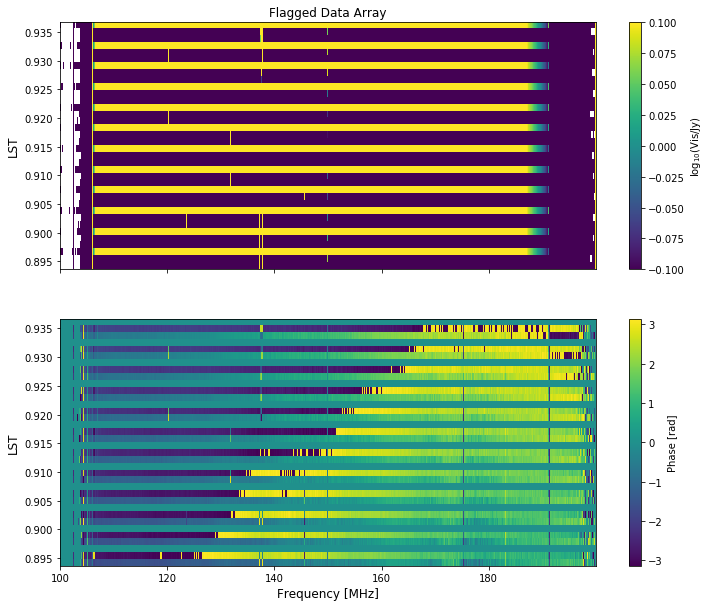

In [7]:
waterfall(uvd.data_array[:,0,:,0], title='Flagged Data Array')

In [8]:
# try1 = [True, False, True , True]
# nottry = np.invert(try1)
# print(nottry)

#### Documentation: Least Squares Delay Filter

In [9]:
help(uvtools.dspec.delay_filter_leastsq)

Help on function delay_filter_leastsq in module uvtools.dspec:

delay_filter_leastsq(data, flags, sigma, nmax, add_noise=False, cn_guess=None, use_linear=True, operator=None)
    Fit a smooth model to each 1D slice of 2D complex-valued data with flags,
    using a linear least-squares solver. The model is a Fourier series up to a
    specified order. As well as calculating a best-fit model, this will also
    return a copy of the data with flagged regions filled in ('in-painted')
    with the smooth solution.
    
    Optionally, you can also add an uncorrelated noise realization on top of
    the smooth model in the flagged region.
    
    N.B. This is just a wrapper around delay_filter_leastsq_1d() but with some
    time-saving precomputations. It fits to each 1D slice of the data
    individually, and does not perform a global fit to the 2D data.
    
    Parameters
    ----------
    data : array_like, complex
        Complex visibility array as a function of frequency, with shape

In [10]:
#2D Data and flag
data = uvd.data_array[:,0,:,0]
flags = uvd.flag_array[:,0,:,0]
sigma = 0.01
nmax = 50

In [11]:
model, model_coeff, data_out = uvtools.dspec.delay_filter_leastsq(data, flags, sigma, nmax)

In [12]:
print(data_out.shape) # in-painted data

(36, 1024)


In [13]:
uvd_new.data_array[:,0,:,0].shape #

(36, 1024)

In [14]:
# waterfall(uvd_new.data_array[:,0,:,0], title='Data Array')

In [15]:
# Replacing original data with in-painted data
uvd_new.data_array[:,0,:,0] = data_out 

#### And this is okay?

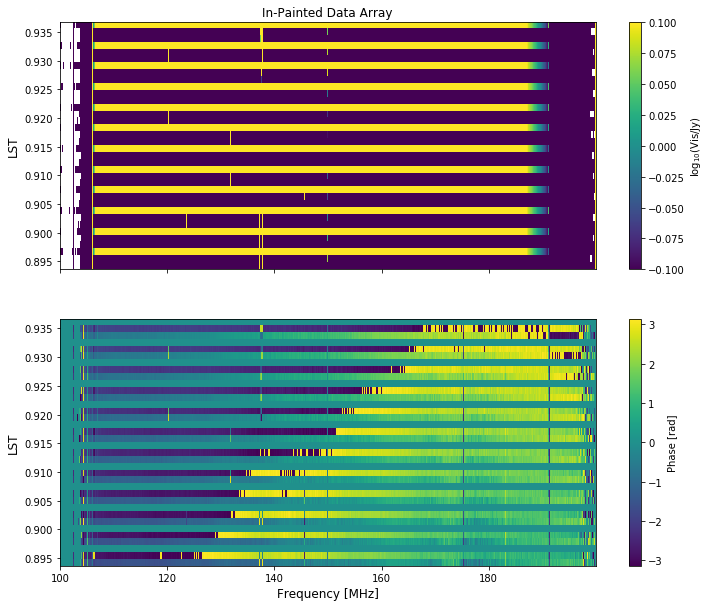

In [16]:
waterfall(uvd_new.data_array[:,0,:,0], title='In-Painted Data Array')

#### Plot power spectra for both flagged data and in-painted data

In [17]:
# Load beam model
beamfile = 'data/HERA_NF_dipole_power.beamfits'
cosmo = hp.conversions.Cosmo_Conversions()
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

# We only have 1 data file here, so slide the time axis by one integration 
# to avoid noise bias (not normally needed!)
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)

# Create a new PSpecData object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)
ds.rephase_to_dset(0) # Phase to the zeroth dataset

# Construct list of baseline pairs to calculate power spectra for
bls = [(24,25), (37,38)]
bls1, bls2, blp = hp.utils.construct_blpairs(bls, exclude_permutations=False, exclude_auto_bls=True)

# Power spectrum calculation
uvp = ds.pspec(bls1, bls2, (0, 1), [('xx', 'xx')], spw_ranges=[(300, 400)], input_data_weight='identity', norm='I', 
               taper='blackman-harris', verbose=False)

#### Power Spectrum of flagged data

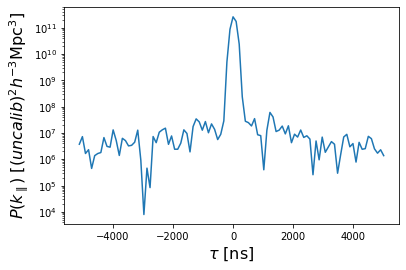

In [18]:
blpairs = np.unique(uvp.blpair_array)
# Unpack the list of baseline-pairs into a Python list
blps = [blp for blp in blpairs]

# Plot the spectra averaged over baseline-pairs and times
ax = hp.plot.delay_spectrum(uvp, [blps,], spw=0, pol=('xx','xx'), average_blpairs=True, average_times=True)

In [ ]:
# Load beam model
beamfile = 'data/HERA_NF_dipole_power.beamfits'
cosmo = hp.conversions.Cosmo_Conversions()
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

# We only have 1 data file here, so slide the time axis by one integration 
# to avoid noise bias (not normally needed!)
uvd_new1 = uvd_new.select(times=np.unique(uvd_new.time_array)[:-1:2], inplace=False)
uvd_new2 = uvd_new.select(times=np.unique(uvd_new.time_array)[1::2], inplace=False)

# Create a new PSpecData object
ds_new = hp.PSpecData(dsets=[uvd_new1, uvd_new2], wgts=[None, None], beam=uvb)
ds_new.rephase_to_dset(0) # Phase to the zeroth dataset

# Construct list of baseline pairs to calculate power spectra for
bls_new = [(24,25), (37,38)]
bls_new1, bls_new2, blp_new = hp.utils.construct_blpairs(bls_new, exclude_permutations=False, exclude_auto_bls=True)

# Power spectrum calculation
uvp_new = ds_new.pspec(bls_new1, bls_new2, (0, 1), [('xx', 'xx')], spw_ranges=[(300, 400)], input_data_weight='identity', norm='I', 
               taper='blackman-harris', verbose=False)

#### Power Spectrum of in-painted data

In [ ]:
blpairs_new = np.unique(uvp_new.blpair_array)
# Unpack the list of baseline-pairs into a Python list
blps_new = [blp_new for blp_new in blpairs_new]

# Plot the spectra averaged over baseline-pairs and times
ax_new =hp.plot.delay_spectrum(uvp_new, [blps_new,], spw=0, pol=('xx','xx'), average_blpairs=True, average_times=True)
